# Model 2/3 training

1. Image classification: 5 classes 
2. Trained with 2-channel images: 1 subcellular localization + 1 nuc-BFP, shape = (2, 150, 150)

Use Python package Keras with Tensorflow backend. Import packages that are needed.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import tifffile
import cv2

In [2]:
# change the directory
train_dir = '../4. Toy example/Training_image' # the directory with the images
model_filepath = "../4. Toy example/test_{epoch:02d}-{val_acc:.2f}.h5" # the directory to save the models

Build a convolutional neural network by assembling layers. In a classification task, the input is the dimension of the image, and the output is the number of classes.

In [14]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

# Build a model
model = models.Sequential()
# The images are 150 by 150 with two channels, so shape=(150,150,2)
model.add(layers.Conv2D(32, (3,3), activation ='relu', input_shape=(150,150,2)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation ='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation ='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation ='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation ='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation ='relu'))
# use softmax function for multiple classes, there are 5 classes here
model.add(layers.Dense(5, activation = 'softmax'))

# print out the model architecture
model.summary()

# compile the model
# use sparse_categorical_crossentropy loss for multiple classification
# use the Adam optimizer
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4, decay=1e-6), metrics=['acc'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      608       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

Read the images. For Keras and Tensorflow, the default configuration of the shape of the image is “channels last,” (ie the array that represents the channels comes after the x and y-axis of the image) so remember to reshape the image if the channels are before x and y-axis.

In [51]:
# read and process the images
def read_and_process_image(list_of_images):
    '''
    returns two arrays:
    X is an array of resized imgs
    y is an array of labels
    '''
    X = []  # images
    y = []  # labels

    for image in list_of_images:
        channel_first_image = cv2.imreadmulti(image)[1]
        X.append(np.dstack((channel_first_image[0],channel_first_image[1])))  
        if 'nucleus' in image:
            y.append(1)
        elif 'membrane' in image:
            y.append(2)
        elif 'nuc_mem' in image:
            y.append(3)
        elif 'cytosol' in image:
            y.append(4)
        else:
            y.append(0)  
      
    # Convert to numpy array
    return np.array(X), np.array(y)

def getListOfFiles(dirName):
    
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

# list training images
train_img = [i for i in getListOfFiles(train_dir) if i.endswith('.tif')]

# separate them into test images and training images
nucleus = [i for i in train_img if 'nucleus' in i]
membrane = [i for i in train_img if 'membrane' in i]
nuc_mem = [i for i in train_img if 'nuc_mem' in i]
cytosol = [i for i in train_img if 'cytosol' in i]
none = [i for i in train_img if 'none' in i]

print('nuc:', len(nucleus), 'mem:', len(membrane), 'nuc_mem:', len(nuc_mem), 'cyt:', len(cytosol), 'none:', len(none))

random.shuffle(nucleus)
random.shuffle(membrane)
random.shuffle(nuc_mem)
random.shuffle(cytosol)
random.shuffle(none)

test_cells = 0 
train_img = nucleus[test_cells:] + membrane[test_cells:] + nuc_mem[test_cells:] + cytosol[test_cells:] + none[test_cells*2:]
test_img = nucleus[:test_cells] + membrane[:test_cells] + nuc_mem[:test_cells] + cytosol[:test_cells] + none[:test_cells*2]

random.shuffle(train_img)
random.shuffle(test_img)

# read and process the images
X, y = read_and_process_image(train_img)

# Convert list to numpy array
X = np.array(X)
y = np.array(y)

# Split the data into train and validation set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 1)


nuc: 150 mem: 150 nuc_mem: 150 cyt: 150 none: 150


Use ImageDataGenerator to augment the images (shift, mirror, rotate, sheer, etc). Rescale the pixel values to be between 0 and 1

In [65]:
# Use data augmentation on the images
# rescale the pixel value of the 8 bit image to be between 0 and 1 by /255
train_datagen = ImageDataGenerator(rescale =1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True) 

val_datagen = ImageDataGenerator(rescale=1./255.)

# set train size and batch size
ntrain = len(X_train)
nval = len(X_val)
batch_size = 8

# create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)


Set epochs to around 100 and start training the model. Save the best models during the training. Usually, it takes a few hours (or a few minutes if using a GPU) to finish training. 

In [66]:
# create checkpoints for epochs
# saves the current model if validation loss is smaller than previous models
checkpoint = ModelCheckpoint(model_filepath, verbose = 1, monitor='val_loss', save_best_only=True, mode='min' )
callbacks_list = [checkpoint]

# train for 100 epochs 
history = model.fit(train_generator,
                    steps_per_epoch = ntrain//batch_size,
                    epochs=100,
                    validation_data=val_generator,
                    validation_steps=nval//batch_size,
                    callbacks=callbacks_list)


Epoch 1/100
75/75 [==============================] - 1s 18ms/step - loss: 0.0397 - acc: 0.9833 - val_loss: 0.3057 - val_acc: 0.9236

Epoch 00001: val_loss improved from inf to 0.30571, saving model to ../4. Toy example\20220515_test_01-0.92.h5
Epoch 2/100
75/75 [==============================] - 1s 18ms/step - loss: 0.1197 - acc: 0.9650 - val_loss: 0.1805 - val_acc: 0.9375

Epoch 00002: val_loss improved from 0.30571 to 0.18049, saving model to ../4. Toy example\20220515_test_02-0.94.h5
Epoch 3/100
75/75 [==============================] - 1s 18ms/step - loss: 0.0787 - acc: 0.9717 - val_loss: 0.3619 - val_acc: 0.8958

Epoch 00003: val_loss did not improve from 0.18049
Epoch 4/100
75/75 [==============================] - 1s 18ms/step - loss: 0.0871 - acc: 0.9733 - val_loss: 0.2626 - val_acc: 0.9167

Epoch 00004: val_loss did not improve from 0.18049
Epoch 5/100
75/75 [==============================] - 1s 18ms/step - loss: 0.0385 - acc: 0.9833 - val_loss: 0.3035 - val_acc: 0.9097

Epoch 0

Plot the history of training accuracy and loss in each epoch. 

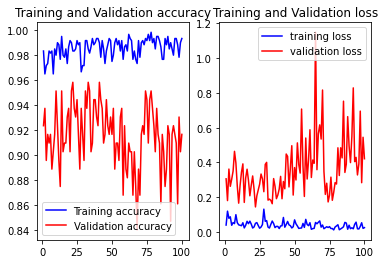

In [69]:
# plot the train and val curve
# get the details from the history object

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

# train and validation accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

# train and validation loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [70]:
# session info
conda_module = !conda list
modulenames = ["tensorflow", "matplotlib", "numpy", "pandas", "tifffile"]
[print(module) for module in conda_module if module.split()[0] in modulenames]
print("cv2 version\t\t ", cv2.__version__)

matplotlib                3.3.4            py38haa95532_0  
numpy                     1.19.5                   pypi_0    pypi
pandas                    1.2.4            py38hd77b12b_0  
tensorflow                2.3.0           mkl_py38h8557ec7_0  
tifffile                  2021.4.8           pyhd3eb1b0_2  
cv2 version		  4.0.1
